<a href="https://colab.research.google.com/github/Michael-Jimenez-C/CieCom2/blob/main/proyecto_CII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sympy as sp

In [ ]:
class Cuarto:
  def __init__(self,capacitancia,temperatura,fuente=0):
    t=sp.symbols("t")
    self.temperatura=temperatura
    self.adyacentes=[]#[(nodo,resistencia)]
    self.capacitancia=capacitancia
    self.fuente=fuente
  def eq(self):
    self.eq=(self.fuente-self.temperatura if self.fuente!=0 else 0)
    for i in self.adyacentes:
      self.eq+=(i[0].temperatura-self.temperatura)*sp.Rational(1,i[1])
    return sp.simplify(self.eq*sp.Rational(1,self.capacitancia))

In [ ]:
t,s=sp.symbols("t s")
T1,T2,T3=sp.symbols("T_1 T_2 T_3")
A=Cuarto(10,T1,sp.symbols("T_i"))
B=Cuarto(5,T2,0)
C=Cuarto(100000,T3,0)

A.adyacentes=[(B,15)]
B.adyacentes=[(A,15),(C,20)]
C.adyacentes=[(A,20)]

nodos=[A,B,C]

In [ ]:
A.eq()

-8*T_1/75 + T_2/150 + T_i/10

In [ ]:
eq=A.eq()

In [ ]:
eq.coeff(T1)

-8/75

In [ ]:
entradas=sp.symbols("T_i T_3")
variables=sp.symbols("T_{1:3}")

In [ ]:
class Edificio:
  pass

r

In [ ]:
t,s=sp.symbols("t s")

A=sp.Matrix([[1,1],[0,-1]])
B=sp.Matrix([[0],[1]])
x0=sp.Matrix([[0],[1]])
u=sp.Matrix([[sp.Heaviside(t)*t]])

In [ ]:
U=sp.Matrix([i[0] for i in sp.laplace_transform(u,t,s)])
Y=(s*sp.eye(A.shape[0])-A).inv()@(x0+B*U)
sol=sp.inverse_laplace_transform(Y,s,t)

In [ ]:
sol

Matrix([
[(-t*exp(t) + exp(2*t) - 1)*exp(-t)*Heaviside(t)],
[   (t*exp(t) - exp(t) + 2)*exp(-t)*Heaviside(t)]])

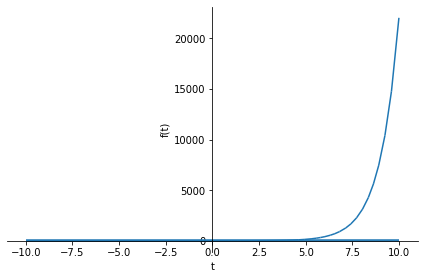

In [ ]:
sp.plot(sol[0],0,100)